# Neural Network Classifier 

We are going to build a PyTorch neural network classifier using scRNAseq data. 

Helpful link:
Interfacing pytorch models with anndata: https://anndata.readthedocs.io/en/latest/tutorials/notebooks/annloader.html

Possibly helpful about speeding up pytorch modeling: https://sebastianraschka.com/blog/2023/pytorch-faster.html

This program will:

- pull in scRNAseq data from cell_census
- wrangle the data for modelling
- appply the NN

At first, we're just going to pick some data from cell_census. Once we get the basics we will modify to select the exact data we want.


## To Do:

- add batch summarization 
- add model.trend() and model.eval()
- train, test, holdout and cross validation
- feature engineering to remove useless features

## Done:
- use softmax for final layer
- use Cross entropy loss
- try ADAM optimizer, adjust learning rate
- plot loss curve
- use RELU for each layer



In [39]:
import cell_census
import anndata as ad

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Read in the data

We are somewhat randomly selecting the data now, but will come back and update this later. Let's just get something working.

Using ```self_reported_ethnicity``` for the target value because there are 16 unique values, so we have a multi-class classification problem, which will match our eventual goal.

In [3]:
census = cell_census.open_soma(census_version="latest")


In [4]:
#  obs_value_filter = 'tissue_ontology_term_id == "UBERON:0002299" and assay == "10x 3\' v3"',


In [5]:
adata = cell_census.get_anndata(
        census=census,
        organism = "Homo sapiens",
        obs_value_filter = 'tissue_ontology_term_id == "UBERON:0002299" and assay == "10x 3\' v3"',
        column_names={"obs": ["development_stage"]},
        )

display(adata)

AnnData object with n_obs × n_vars = 57747 × 60664
    obs: 'development_stage', 'tissue_ontology_term_id', 'assay'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [6]:
# the data is stored in adata.X
adata.X

<57747x60664 sparse matrix of type '<class 'numpy.float32'>'
	with 136730898 stored elements in Compressed Sparse Row format>

Only 3.9% of the entries have values.

In [7]:
# find the number of features (genes)

adata.X.shape[1]

# returns 2.0
#adata.X[0,40]

60664

## Encode and Split the Data to prepare for modeling

Encode the label values, then split the data into testing and training sets, then put into PyTorch Tensors.

Using self_reported_ethnicity for the labels

In [8]:
# select the labels. 
labels = adata.obs

In [9]:
labels.head()

,development_stage,tissue_ontology_term_id,assay
0,63-year-old human stage,UBERON:0002299,10x 3' v3
1,63-year-old human stage,UBERON:0002299,10x 3' v3
2,63-year-old human stage,UBERON:0002299,10x 3' v3
3,63-year-old human stage,UBERON:0002299,10x 3' v3
4,63-year-old human stage,UBERON:0002299,10x 3' v3


In [10]:
labels['development_stage'].value_counts()

63-year-old human stage    19164
73-year-old human stage    11752
65-year-old human stage    11743
61-year-old human stage     8312
60-year-old human stage     6776
Name: development_stage, dtype: int64

In [11]:
lb = LabelEncoder()
labels['encoded_labels'] = lb.fit_transform(labels['development_stage'])
labels.head(10)

,development_stage,tissue_ontology_term_id,assay,encoded_labels
0,63-year-old human stage,UBERON:0002299,10x 3' v3,2
1,63-year-old human stage,UBERON:0002299,10x 3' v3,2
2,63-year-old human stage,UBERON:0002299,10x 3' v3,2
3,63-year-old human stage,UBERON:0002299,10x 3' v3,2
4,63-year-old human stage,UBERON:0002299,10x 3' v3,2
5,63-year-old human stage,UBERON:0002299,10x 3' v3,2
6,63-year-old human stage,UBERON:0002299,10x 3' v3,2
7,63-year-old human stage,UBERON:0002299,10x 3' v3,2
8,63-year-old human stage,UBERON:0002299,10x 3' v3,2
9,63-year-old human stage,UBERON:0002299,10x 3' v3,2


In [12]:
# find the number of unique labels
labels['encoded_labels'].nunique()

5

In [13]:
y_data = labels['encoded_labels']

In [14]:
x_data = adata.X.copy()

In [15]:
y_data.shape

(57747,)

In [16]:
x_data

<57747x60664 sparse matrix of type '<class 'numpy.float32'>'
	with 136730898 stored elements in Compressed Sparse Row format>

In [17]:
# create training and testing sets here

# using a very small train size to speed up development for now


X_train, X_test, y_train, y_test = train_test_split(x_data,y_data,
                                                   train_size = 0.1)


In [18]:
# convert the data to tensors
# we'll change the data from CSR (compressed sparse row) format
# to COO (coordinate) format for better use with pytorch
# see https://pytorch.org/docs/stable/sparse.html for some details/thoughts



X_train_coo = X_train.tocoo()

X_train = torch.sparse.LongTensor(torch.LongTensor([X_train_coo.row.tolist(),X_train_coo.col.tolist()]),
                                 torch.LongTensor(X_train_coo.data.astype(np.float32)))

# y_train is a Series, so it is easier to convert to a tensor
y_train = torch.tensor(y_train, dtype=torch.long)



# and the same for the test set
X_test_coo = X_test.tocoo()

X_test = torch.sparse.LongTensor(torch.LongTensor([X_test_coo.row.tolist(),X_test_coo.col.tolist()]),
                                 torch.LongTensor(X_test_coo.data.astype(np.float32)))

# y_train is a Series, so it is easier to convert to a tensor
y_test = torch.tensor(y_test, dtype=torch.long)



In [19]:
X_train

tensor(indices=tensor([[    0,     0,     0,  ...,  5773,  5773,  5773],
                       [   11,    16,    25,  ..., 21455, 21859, 26270]]),
       values=tensor([ 1, 17,  1,  ...,  1,  1,  1]),
       size=(5774, 56710), nnz=13617125, layout=torch.sparse_coo)

In [20]:
y_train

tensor([2, 2, 4,  ..., 2, 4, 2])

## Build Neural Network Classifier

based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

In [21]:
test_size = torch.unique(y_train).size(dim=0)

test_size

5

In [22]:
# number of features (len of X cols)
# select the number of gene columns
input_dim = X_train.size(dim=1) #adata.X.shape[1] 

# number of hidden layers
hidden_layers = 2

# number of classes (unique of y)
output_dim = torch.unique(y_train).size(dim=0) #labels['encoded_labels'].nunique()

In [23]:
print(input_dim,hidden_layers,output_dim)

56710 2 5


In [97]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layers)
        self.linear2 = nn.Linear(hidden_layers,output_dim)
        
    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.softmax(x,dim=1)
        return x

In [98]:
# initialize network

clf = Network()

In [99]:
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3)

In [123]:
epochs = 10
accuracy_vals = []
loss_vals = []

for epoch in range(epochs):
    running_loss = 0.0

    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()
  
    # forward propagation
    outputs = clf(X_train.float())
    loss = criterion(outputs, y_train)
    
    # save accuracy
    _, epoch_pred = outputs.max(dim=1)
    corect = (epoch_pred == y_train).sum().item()
    print(correct)
    accuracy_vals.append(correct / len(y_train))
    print(accuracy_vals)
    print('')
    # save loss
    loss_vals.append(loss.item())
    
    
    # backward propagation
    loss.backward()
    
    # optimize
    optimizer.step()
    running_loss += loss.item()
    
    
    
    # display statistics
    #print(f'[{epoch + 1}] loss: {running_loss:.8f}')


0
[0.0]

0
[0.0, 0.0]

0
[0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



In [121]:
#print((epoch_pred == y_train).sum())
#print((epoch_pred == y_train).sum().item())
#print(len(epoch_pred == y_train))
print((epoch_pred == y_train).sum().item())
print(correct)

2805
0


In [118]:
#len(y_train)
print(outputs)
print(epoch_pred)
print(y_train)

print(correct)
print(len(y_train))

tensor([[1.8068e-04, 1.7509e-05, 6.8748e-01, 5.3737e-05, 3.1227e-01],
        [1.6974e-02, 4.4686e-03, 6.5224e-01, 7.7192e-03, 3.1860e-01],
        [7.9363e-04, 1.0630e-04, 6.8177e-01, 2.7084e-04, 3.1706e-01],
        ...,
        [1.9841e-02, 5.4112e-03, 6.4817e-01, 9.1596e-03, 3.1742e-01],
        [3.2692e-06, 1.3182e-07, 7.0118e-01, 6.6986e-07, 2.9882e-01],
        [2.0220e-01, 1.0265e-01, 3.7928e-01, 1.2155e-01, 1.9433e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([2, 2, 4,  ..., 2, 4, 2])
17153
5774


/var/folders/gy/qftxzz157cz4xv36kyp3yp59ztxvbq/T/ipykernel_54979/620898164.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


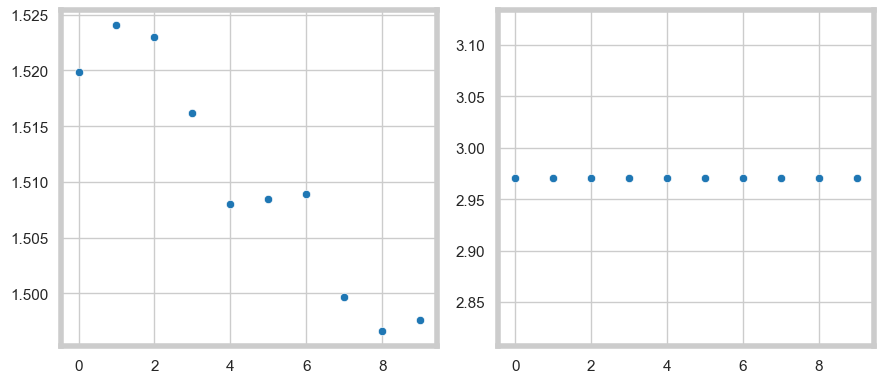

In [119]:
# plot the loss

fig, ax = plt.subplots(1,2,figsize=(9,4))
sns.scatterplot(x=range(epochs),y=loss_vals, ax = ax[0])
sns.scatterplot(x=range(epochs),y=accuracy_vals, ax = ax[1])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
fig.show()

In [101]:
# make predictions on the test data

pred_model = clf(X_test.float())
_, y_pred = pred_model.max(1)
print('Model Predictions on test data: ')
print(y_pred)

Model Predictions on test data: 
tensor([2, 2, 2,  ..., 2, 2, 0])


In [102]:
torch.unique(y_pred, return_counts=True)

(tensor([0, 2, 3, 4]), tensor([ 1058, 50516,     5,   394]))

In [103]:
# CHECK MODEL ACCURARY

correct = (y_test == y_pred).sum().item()
acc = correct / len(X_test)
print('Model accuracy: ', acc)

Model accuracy:  0.3300367498508841


### Test the model

Most of this work is based on https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2

**Check the torch.max line. Why do we do this/is it needed?**

In [34]:
outputs_test = clf(X_test.float())
__, predicted = torch.max(outputs_test,1)
print(predicted)

tensor([3, 3, 3,  ..., 3, 3, 3])


In [38]:
torch.unique(predicted, return_counts=True)

(tensor([3, 4]), tensor([51507,   466]))

In [39]:
51507/56710

0.9082525127843414

In [35]:
correct, total = 0, 0

with torch.no_grad():
    # calculate output by running through the network
    outputs = clf(X_test.float())
    
    # get the predictions
    __, predicted = torch.max(outputs.data, 1)
    
    # update results
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()
    
print(f'Accuracy of the network on the test data: {100 * correct // total} %')

Accuracy of the network on the test data: 20 %
